In [ ]:
!pip install ultralytics --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.6 MB/s eta 0:00:00


In [ ]:
import zipfile

# Path to your uploaded dataset
zip_path = '/content/road_datase.zip'
extract_folder = '/content/road_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Extraction completed!")

Extraction completed!


In [ ]:
import os
import xml.etree.ElementTree as ET

# Paths
annotations_dir = '/content/road_dataset/road_datase/annotations'
images_dir = '/content/road_dataset/road_datase/images'
output_dir = '/content/YOLO_dataset/labels'

os.makedirs(output_dir, exist_ok=True)

# Extract class names
classes = set()
for xml_file in os.listdir(annotations_dir):
    tree = ET.parse(os.path.join(annotations_dir, xml_file))
    for obj in tree.findall('object'):
        classes.add(obj.find('name').text)

classes = sorted(list(classes))
print("Detected Classes:", classes)

# Save class list
with open('/content/YOLO_dataset/classes.txt', 'w') as f:
    for cls in classes:
        f.write(cls + '\n')

# Convert to YOLO format
def convert(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find('size')
    img_w = int(size.find('width').text)
    img_h = int(size.find('height').text)

    yolo_data = []

    for obj in root.findall('object'):
        cls_id = classes.index(obj.find('name').text)
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        x_center = (xmin + xmax) / 2 / img_w
        y_center = (ymin + ymax) / 2 / img_h
        width = (xmax - xmin) / img_w
        height = (ymax - ymin) / img_h

        yolo_data.append(f"{cls_id} {x_center} {y_center} {width} {height}")
    return yolo_data

for xml_file in os.listdir(annotations_dir):
    image_filename = xml_file.replace('.xml', '.png')
    if not os.path.exists(os.path.join(images_dir, image_filename)):
        continue  # Skip if image not found

    yolo_annotations = convert(os.path.join(annotations_dir, xml_file))
    label_path = os.path.join(output_dir, xml_file.replace('.xml', '.txt'))

    with open(label_path, 'w') as f:
        f.write('\n'.join(yolo_annotations))

print("Conversion to YOLO format completed.")

Detected Classes: ['crosswalk', 'speedlimit', 'stop', 'trafficlight']
Conversion to YOLO format completed.


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Create folders
for split in ['train', 'val']:
    os.makedirs(f'/content/YOLO_dataset/images/{split}', exist_ok=True)
    os.makedirs(f'/content/YOLO_dataset/labels/{split}', exist_ok=True)

# Split data
image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Move files
def move_files(file_list, split):
    for img_name in file_list:
        label_name = img_name.replace('.png', '.txt')
        if os.path.exists(f'/content/YOLO_dataset/labels/{label_name}'):
            shutil.copyfile(f'{images_dir}/{img_name}', f'/content/YOLO_dataset/images/{split}/{img_name}')
            shutil.copyfile(f'/content/YOLO_dataset/labels/{label_name}', f'/content/YOLO_dataset/labels/{split}/{label_name}')

move_files(train_files, 'train')
move_files(val_files, 'val')

print(f"Training and Validation sets are ready!")


Training and Validation sets are ready!


In [ ]:
dataset_yaml = """
path: /content/YOLO_dataset
train: images/train
val: images/val

names: {}
""".format(classes)

with open('/content/YOLO_dataset/data.yaml', 'w') as f:
    f.write(dataset_yaml)

print("YOLO dataset config file created!")

YOLO dataset config file created!


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # 'n' = nano model, light and fast

model.train(data='/content/YOLO_dataset/data.yaml', epochs=20, imgsz=640, batch=16)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 259MB/s]


Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/YOLO_dataset/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt

100%|██████████| 755k/755k [00:00<00:00, 90.3MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/YOLO_dataset/labels/train... 225 images, 0 backgrounds, 0 corrupt: 100%|██████████| 225/225 [00:00<00:00, 851.57it/s]

train: New cache created: /content/YOLO_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2266.5±450.4 MB/s, size: 176.6 KB)


val: Scanning /content/YOLO_dataset/labels/val... 57 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57/57 [00:00<00:00, 944.27it/s]

val: New cache created: /content/YOLO_dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G     0.8626      3.576      1.068          3        640: 100%|██████████| 15/15 [03:11<00:00, 12.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.00s/it]

                   all         57         86    0.00364      0.718      0.342      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G     0.8303      2.238     0.9892          1        640: 100%|██████████| 15/15 [03:07<00:00, 12.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.63s/it]

                   all         57         86    0.00369      0.777      0.589      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G     0.8323      1.799      0.997          2        640: 100%|██████████| 15/15 [03:04<00:00, 12.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.63s/it]

                   all         57         86      0.955      0.145      0.557      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      0.912      1.739      1.011          2        640: 100%|██████████| 15/15 [03:02<00:00, 12.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.63s/it]

                   all         57         86      0.753      0.397      0.529      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G     0.8779      1.541      1.027          3        640: 100%|██████████| 15/15 [03:08<00:00, 12.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.63s/it]

                   all         57         86      0.844       0.37      0.636       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G     0.8884      1.509      1.008          2        640: 100%|██████████| 15/15 [03:04<00:00, 12.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.60s/it]

                   all         57         86      0.676      0.455      0.616       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      1.007      1.802       1.25          1        640: 100%|██████████| 15/15 [03:04<00:00, 12.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.62s/it]

                   all         57         86      0.592      0.611      0.705      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G     0.8477      1.398     0.9814          4        640: 100%|██████████| 15/15 [03:05<00:00, 12.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.83s/it]

                   all         57         86      0.683      0.673      0.765      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G     0.8172      1.296     0.9911          4        640: 100%|██████████| 15/15 [03:07<00:00, 12.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.79s/it]

                   all         57         86      0.827      0.548      0.712      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G     0.8757      1.354     0.9986          2        640: 100%|██████████| 15/15 [03:05<00:00, 12.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.57s/it]

                   all         57         86      0.918      0.808      0.859      0.678


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G     0.7916      1.583     0.9209          1        640: 100%|██████████| 15/15 [03:03<00:00, 12.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.67s/it]

                   all         57         86      0.886      0.892      0.919      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G     0.7305      1.566     0.9175          1        640: 100%|██████████| 15/15 [03:03<00:00, 12.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.81s/it]

                   all         57         86      0.837       0.92      0.928      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G     0.7441      1.475     0.9249          1        640: 100%|██████████| 15/15 [03:03<00:00, 12.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.07s/it]

                   all         57         86      0.893      0.904      0.928      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G     0.7519      1.531     0.9354          1        640: 100%|██████████| 15/15 [03:02<00:00, 12.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.85s/it]

                   all         57         86      0.872      0.838      0.914      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G     0.7883      1.395     0.9108          1        640: 100%|██████████| 15/15 [03:03<00:00, 12.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.85s/it]

                   all         57         86      0.904       0.89      0.929      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G     0.7037      1.234     0.8902          1        640: 100%|██████████| 15/15 [03:02<00:00, 12.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.96s/it]

                   all         57         86       0.95      0.881      0.941      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G     0.6572       1.17     0.9016          1        640: 100%|██████████| 15/15 [03:02<00:00, 12.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.98s/it]

                   all         57         86      0.906      0.895      0.929      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G     0.6626      1.162     0.8855          1        640: 100%|██████████| 15/15 [03:02<00:00, 12.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.80s/it]

                   all         57         86      0.931      0.917      0.932      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G     0.6857       1.18     0.8983          1        640: 100%|██████████| 15/15 [03:02<00:00, 12.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.69s/it]

                   all         57         86      0.912      0.913       0.93      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G     0.6364      1.095     0.8774          1        640: 100%|██████████| 15/15 [03:05<00:00, 12.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.97s/it]

                   all         57         86      0.934      0.914      0.925      0.761



20 epochs completed in 1.114 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.95s/it]


                   all         57         86       0.95      0.881      0.941      0.777
             crosswalk         13         16          1      0.836      0.991      0.831
            speedlimit         28         33      0.937       0.97      0.982      0.781
                  stop         12         12      0.972          1      0.995      0.916
          trafficlight         15         25      0.891       0.72      0.794      0.581
Speed: 2.2ms preprocess, 217.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79c8f56d65d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2212.4±393.4 MB/s, size: 195.1 KB)


val: Scanning /content/YOLO_dataset/labels/val.cache... 57 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57/57 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.41s/it]


                   all         57         86       0.95      0.883      0.941      0.786
             crosswalk         13         16          1      0.842      0.988      0.856
            speedlimit         28         33      0.937       0.97      0.982      0.781
                  stop         12         12      0.972          1      0.995      0.924
          trafficlight         15         25      0.892       0.72      0.796      0.584
Speed: 1.7ms preprocess, 207.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79c90ef9ab50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,

In [ ]:
model.export(format='onnx')
model.export(format='torchscript')

print("Model exported to multiple formats.")

Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (5.9 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.50...
ONNX: export success ✅ 1.3s, saved as 'runs/detect/train/weights/best.onnx' (11.7 MB)

Export complete (1.8s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.onnx imgsz=640 data=/content/YOLO_dataset/data.yaml  
Visualize:       https://netron.app
Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (5.9 MB)

TorchScript: starting export with torch 2.6

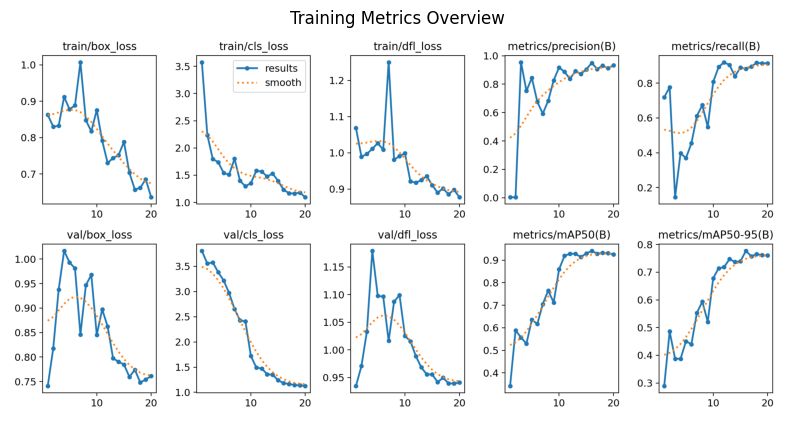

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the results graph generated by YOLO
result_graph = Image.open('/content/runs/detect/train/results.png')

# Display it in notebook
plt.figure(figsize=(10,8))
plt.imshow(result_graph)
plt.axis('off')
plt.title("Training Metrics Overview")
plt.show()

In [ ]:
from ultralytics import YOLO
import os

# Load your best trained model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Create a directory for prediction results
os.makedirs('/content/predictions', exist_ok=True)

# Predict on images — replace with your image path or a folder
results = model.predict(
    source='/content/YOLO_dataset/images/val',  # change to any path you like
    save=True,
    save_txt=True,
    save_conf=True,
    project='/content/predictions',
    name='yolo_results',
    imgsz=640,
    conf=0.25
)

print("✅ Prediction complete! Check '/content/predictions/yolo_results/' for output images and labels.")


image 1/57 /content/YOLO_dataset/images/val/road0.png: 640x448 (no detections), 172.2ms
image 2/57 /content/YOLO_dataset/images/val/road104.png: 608x640 1 speedlimit, 224.5ms
image 3/57 /content/YOLO_dataset/images/val/road106.png: 640x448 1 speedlimit, 156.7ms
image 4/57 /content/YOLO_dataset/images/val/road108.png: 416x640 1 speedlimit, 168.5ms
image 5/57 /content/YOLO_dataset/images/val/road110.png: 448x640 1 speedlimit, 165.9ms
image 6/57 /content/YOLO_dataset/images/val/road113.png: 448x640 1 speedlimit, 156.5ms
image 7/57 /content/YOLO_dataset/images/val/road120.png: 480x640 1 speedlimit, 175.1ms
image 8/57 /content/YOLO_dataset/images/val/road135.png: 416x640 1 crosswalk, 142.7ms
image 9/57 /content/YOLO_dataset/images/val/road140.png: 448x640 1 crosswalk, 167.5ms
image 10/57 /content/YOLO_dataset/images/val/road15.png: 448x640 2 trafficlights, 157.0ms
image 11/57 /content/YOLO_dataset/images/val/road152.png: 384x640 1 crosswalk, 231.5ms
image 12/57 /content/YOLO_dataset/images